In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('C:/Users/Patyc/OneDrive/Desktop/Dissertation/Data/Skin_clean and treated/Skin_clean_location.xlsx')
df['Location'] = df['Location'].str.strip()
df.loc[df['Location'].eq('Faro') & df['Screening_date'].eq('2022-08-13'), 'Screening_date'] = '2022-08-14'
df.loc[df['Location'].eq('Lisboa') & df['Screening_date'].eq('2023-05-15'), 'Screening_date'] = '2023-05-19'

df.head()

## Converter a data para datetime e ordenar de forma crescente
df['Screening_date'] = pd.to_datetime(df['Screening_date'])
df = df.sort_values(by='Screening_date')

d1 = df.groupby(['Location', 'Screening_date'], as_index=False).size().sort_values(['Location', 'Screening_date'])
d2 = d1.assign(count = d1.groupby(['Location'])['Location'].transform('count'))
d2 = d2[d2['count'].ne(1)]

d2['ndays'] = d2.groupby('Location')['Screening_date'].diff()
d2['nscreens'] = d2['size'].values/d2['ndays'].dt.days
d2

date_range = pd.date_range(start='2022-03-03', end='2024-04-20') #datas mais extremas no dataset

datesdf = pd.DataFrame(date_range, columns=['Screening_date'])

list_dfs = []

groups = d2.groupby('Location')

for _, group in groups:
    list_dfs.append(datesdf.merge(group, how='left').bfill().ffill())

d3 = pd.concat(list_dfs)
d3

# Agrupar por 'Screening_date' e somar a coluna 'nscreens'
d4 = d3.groupby('Screening_date', as_index=False)['nscreens'].sum()

# Exibir o resultado
print(d4)

    Screening_date   nscreens
0       2022-03-03  11.169861
1       2022-03-04  11.169861
2       2022-03-05  11.169861
3       2022-03-06  11.169861
4       2022-03-07  11.169861
..             ...        ...
775     2024-04-16  12.874846
776     2024-04-17  12.874846
777     2024-04-18  12.874846
778     2024-04-19  12.874846
779     2024-04-20  12.874846

[780 rows x 2 columns]


# ANÁLISE NSCREENS

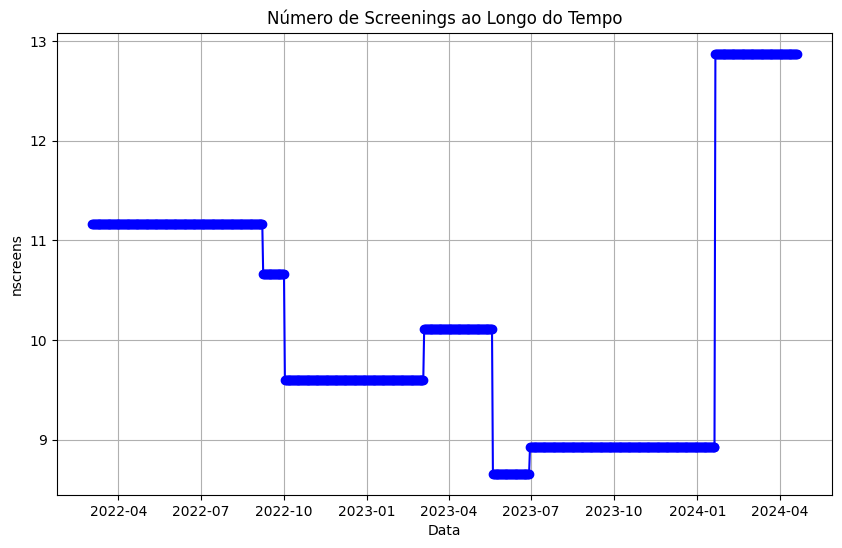

In [3]:
import matplotlib.pyplot as plt

# Plotando 'nscreens' ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(d4['Screening_date'], d4['nscreens'], marker='o', linestyle='-', color='b')
plt.title('Número de Screenings ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('nscreens')
plt.grid(True)
plt.show()

In [4]:
# Verificar se há NaNs na coluna 'nscreens'
has_nan = d4['nscreens'].isnull().any()

has_nan

False

In [5]:
print(d4['nscreens'].describe())

count    780.000000
mean      10.218097
std        1.301990
min        8.657425
25%        8.924788
50%        9.601172
75%       11.169861
max       12.874846
Name: nscreens, dtype: float64


ESTACIONARIEDADE

In [6]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(d4['nscreens'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.1583735563439237
p-value: 0.6912413038161388


Diferenciar torna os valores 0

DECOMPOSIÇÃO TEMPORAL

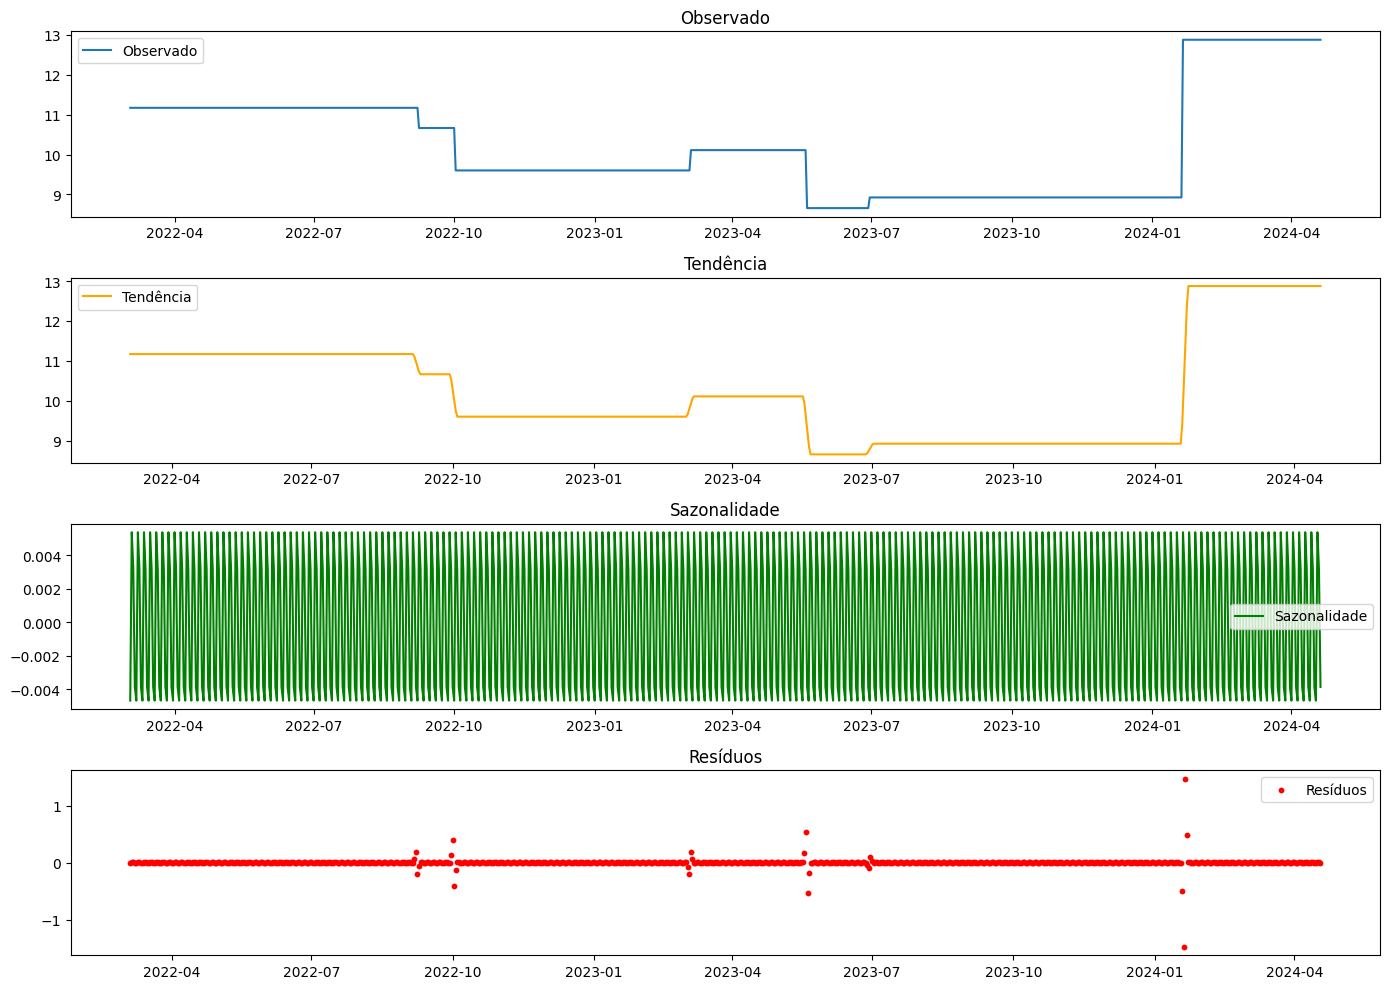

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Definir a série temporal com a frequência correta (semana)
d4.set_index('Screening_date', inplace=True)
series = d4['nscreens']

# Aplicar a decomposição
decomposition = seasonal_decompose(series, model='additive', period=4)  # period=52 para dados semanais

# Plotar a decomposição
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observado')
plt.title('Observado')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Tendência', color='orange')
plt.title('Tendência')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Sazonalidade', color='green')
plt.title('Sazonalidade')
plt.legend()

# Gráfico dos Resíduos como pontos
plt.subplot(4, 1, 4)
plt.scatter(decomposition.resid.index, decomposition.resid, label='Resíduos', color='red', s=10)  # s é o tamanho dos pontos
plt.title('Resíduos')
plt.legend()

plt.tight_layout()
plt.show()


Tendência Decrescente com Recuperação: A série temporal mostra uma tendência decrescente até meados de 2023, seguida por uma recuperação no início de 2024. Esse padrão pode indicar ciclos econômicos, mudanças sazonais, ou impactos de eventos externos.

Sazonalidade Fraca: A sazonalidade tem um impacto mínimo na série, sugerindo que os fatores sazonais não são os principais responsáveis pelas variações observadas.

Resíduos e Outliers: Há alguns resíduos significativos que aparecem como outliers. Eles podem ser pontos de interesse para uma investigação mais detalhada, possivelmente indicando anomalias ou mudanças repentinas nos dados que não foram explicadas pela tendência ou sazonalidade

AUTOCORRELAÇÃO E PARCIAL AUTOCORRELAÇÃO

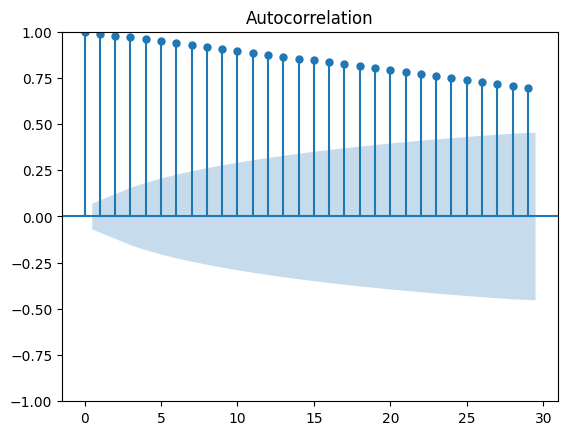

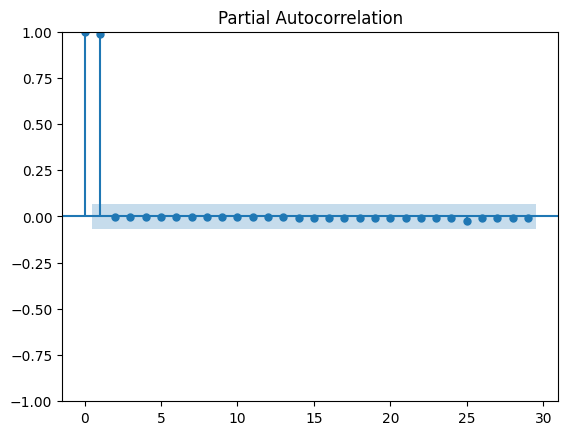

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(d4['nscreens'])
plot_pacf(d4['nscreens'])
plt.show()

# MODELO AR

Given the PACF's first lag significance, an AR(1) model could be considered. However, due to the seasonality, this model alone might not be sufficient.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg

In [5]:
# # Dividir o conjunto de dados em treino e teste baseado na data
# train = d4['nscreens'][:'2024-02-29']  # Dados até 29-02-2024, exclusivo
# test = d4['nscreens']['2024-03-01':]   # Dados a partir de 01-03-2024

TypeError: cannot do slice indexing on RangeIndex with these indexers [2024-02-29] of type str

In [39]:
# # Definir a proporção de treino
# train_size = int(len(series) * 0.8) 

# # Dividir a série em treino e teste
# train, test = series[:train_size], series[train_size:]

AR(1)

In [13]:
# Ajustar o modelo AR(1) no conjunto de treino
model = AutoReg(train, lags=1)
model_fitted = model.fit()

# Fazer previsões no conjunto de teste
predictions = model_fitted.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


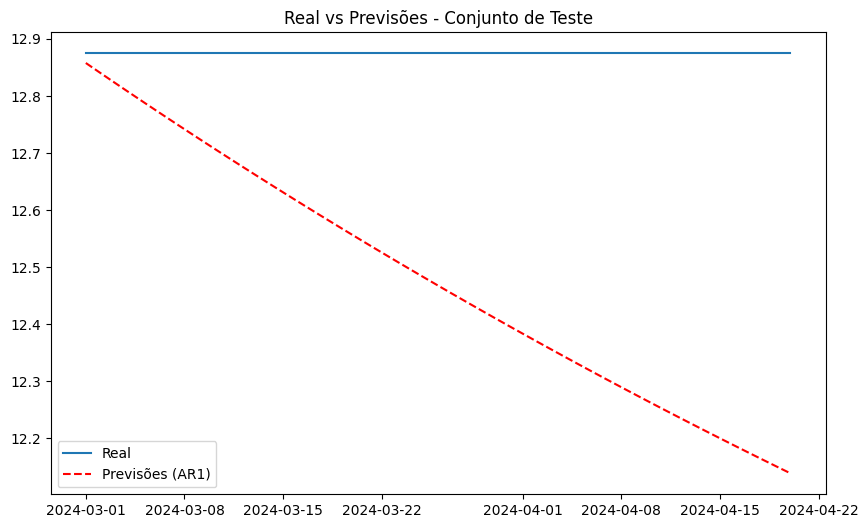

In [14]:
# Plotar os valores reais vs previsões
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Real')
plt.plot(test.index, predictions, color='red', linestyle='--', label='Previsões (AR1)')
plt.title('Real vs Previsões - Conjunto de Teste')
plt.legend()
plt.show()

In [15]:
# Calcular as métricas de avaliação
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test, predictions)
me = np.mean(test - predictions)
mav = np.mean(np.abs(test))
mpv = np.mean(np.abs((test - predictions) / test))
rme = np.mean((test - predictions) / test)
rmae = np.mean(np.abs(test - predictions) / np.abs(test))

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2 Score: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# random split
# Mean Squared Error: 8.888427772244656
# Mean Absolute Error: 2.2836392166526096
# RMSE: 2.9813466373846325
# R^2 Score: -1.3437562028847858
# ME: 2.2703962144219454
# MAV: 11.228988121444878
# MPV: 0.1775997876551905
# RME: 0.176115942565009
# RMAE: 0.1775997876551905

#split date
# Mean Squared Error: 0.20215338688344567
# Mean Absolute Error: 0.39671947704368266
# RMSE: 0.44961470937175274
# R^2 Score: -6.4064965555242344e+28
# ME: 0.39671947704368266
# MAV: 12.874845651448746
# MPV: 0.03081353266546086
# RME: 0.03081353266546086
# RMAE: 0.03081353266546086

Mean Squared Error: 0.20215338688344567
Mean Absolute Error: 0.39671947704368266
RMSE: 0.44961470937175274
R^2 Score: -6.4064965555242344e+28
ME: 0.39671947704368266
MAV: 12.874845651448746
MPV: 0.03081353266546086
RME: 0.03081353266546086
RMAE: 0.03081353266546086


AR(2)

In [16]:
# Ajustar o modelo AR(1) no conjunto de treino
model2 = AutoReg(train, lags=2)
model_fitted = model2.fit()

# Fazer previsões no conjunto de teste
predictions2 = model_fitted.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


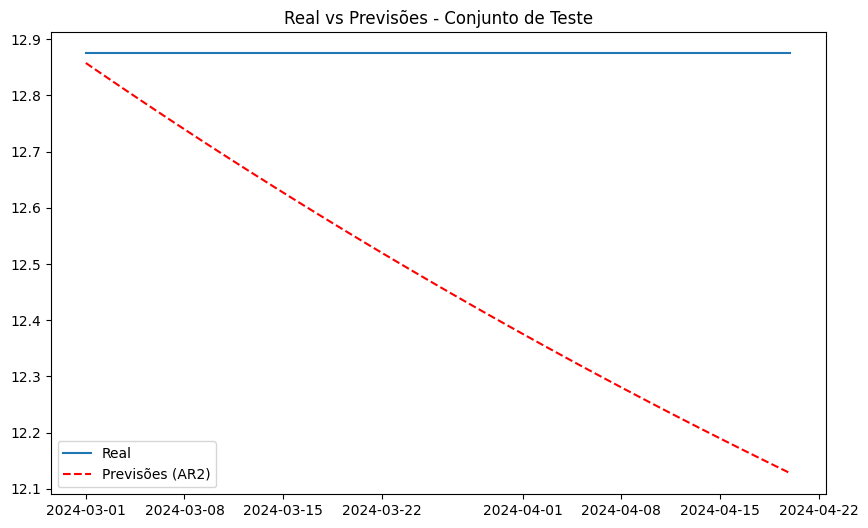

In [17]:
# Plotar os valores reais vs previsões
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Real')
plt.plot(test.index, predictions2, color='red', linestyle='--', label='Previsões (AR2)')
plt.title('Real vs Previsões - Conjunto de Teste')
plt.legend()
plt.show()

In [18]:
# Calcular as métricas de avaliação
mse = mean_squared_error(test, predictions2)
mae = mean_absolute_error(test, predictions2)
rmse = np.sqrt(mse)
r2 = r2_score(test, predictions2)
me = np.mean(test - predictions2)
mav = np.mean(np.abs(test))
mpv = np.mean(np.abs((test - predictions2) / test))
rme = np.mean((test - predictions2) / test)
rmae = np.mean(np.abs(test - predictions2) / np.abs(test))



In [19]:
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2 Score: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# random split
# Mean Squared Error: 8.886993885057386
# Mean Absolute Error: 2.283503728294848
# RMSE: 2.981106151256172
# R^2 Score: -1.3433781065469952
# ME: 2.270163701281642
# MAV: 11.228988121444878
# MPV: 0.17759093185496758
# RME: 0.17609621538194603
# RMAE: 0.17759093185496758

# split date
# Mean Squared Error: 0.20838501633785944
# Mean Absolute Error: 0.40284827688744224
# RMSE: 0.45649207697161565
# R^2 Score: -6.603984775981423e+28
# ME: 0.40284827688744224
# MAV: 12.874845651448746
# MPV: 0.03128956166104496
# RME: 0.03128956166104496
# RMAE: 0.03128956166104496

Mean Squared Error: 0.20838501633785944
Mean Absolute Error: 0.40284827688744224
RMSE: 0.45649207697161565
R^2 Score: -6.603984775981423e+28
ME: 0.40284827688744224
MAV: 12.874845651448746
MPV: 0.03128956166104496
RME: 0.03128956166104496
RMAE: 0.03128956166104496


AR(1) SEM OUTLIERS

In [47]:
import pandas as pd
import numpy as np
from scipy import stats

# Supondo que 'Screening_date' seja o índice e 'nscreens' seja a série temporal
d4.set_index('Screening_date', inplace=True)
series = d4['nscreens']

# Identificação de outliers usando o método IQR
Q1 = series.quantile(0.25)
Q3 = series.quantile(0.75)
IQR = Q3 - Q1

# Definindo limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removendo outliers
series_no_outliers = series[(series >= lower_bound) & (series <= upper_bound)]


In [48]:
# Dividir a série sem outliers em treino e teste 
train_size = int(len(series_no_outliers) * 0.8)
train_no_outliers, test_no_outliers = series_no_outliers[:train_size], series_no_outliers[train_size:]


In [49]:
from statsmodels.tsa.ar_model import AutoReg

# Ajustar o modelo AR(1) no conjunto de treino sem outliers
model_no_outliers = AutoReg(train_no_outliers, lags=1)
model_fitted_no_outliers = model_no_outliers.fit()

# Fazer previsões no conjunto de teste sem outliers
predictions_no_outliers = model_fitted_no_outliers.predict(start=len(train_no_outliers), end=len(train_no_outliers) + len(test_no_outliers) - 1, dynamic=False)


c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


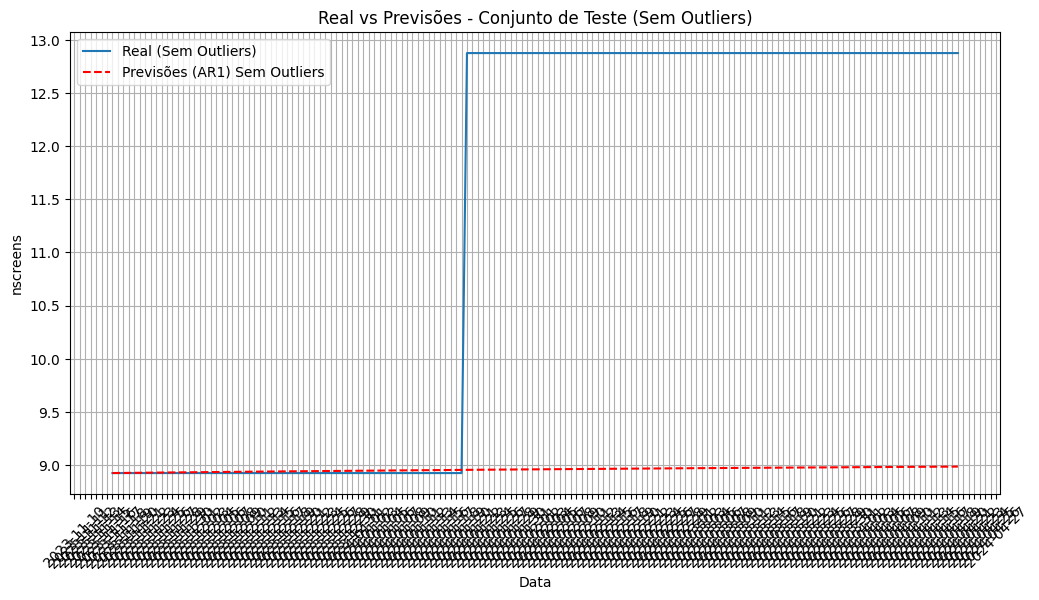

Mean Squared Error: 8.888427772244656
Mean Absolute Error: 2.2836392166526096
RMSE: 2.9813466373846325
R^2 Score: -1.3437562028847858
ME: 2.2703962144219454
MAV: 11.228988121444878
MPV: 0.1775997876551905
RME: 0.176115942565009
RMAE: 0.1775997876551905


In [53]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plotar os valores reais vs previsões sem outliers
plt.figure(figsize=(12, 6))
plt.plot(test_no_outliers.index, test_no_outliers, label='Real (Sem Outliers)')
plt.plot(test_no_outliers.index, predictions_no_outliers, color='red', linestyle='--', label='Previsões (AR1) Sem Outliers')
plt.title('Real vs Previsões - Conjunto de Teste (Sem Outliers)')
plt.xlabel('Data')
plt.ylabel('nscreens')
plt.legend()

# Formatar o eixo X para mostrar todas as datas
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Ajuste o intervalo se necessário

plt.grid(True)
plt.show()

# Calcular as métricas de avaliação
mse = mean_squared_error(test_no_outliers, predictions_no_outliers)
mae = mean_absolute_error(test_no_outliers, predictions_no_outliers)
rmse = np.sqrt(mse)
r2 = r2_score(test_no_outliers, predictions_no_outliers)
me = np.mean(test_no_outliers - predictions_no_outliers)
mav = np.mean(np.abs(test_no_outliers))
mpv = np.mean(np.abs((test_no_outliers - predictions_no_outliers) / test_no_outliers))
rme = np.mean((test_no_outliers - predictions_no_outliers) / test_no_outliers)
rmae = np.mean(np.abs(test_no_outliers - predictions_no_outliers) / np.abs(test_no_outliers))

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'RMSE: {rmse}')
print(f'R^2 Score: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')


LOG TRANSFORMATION

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


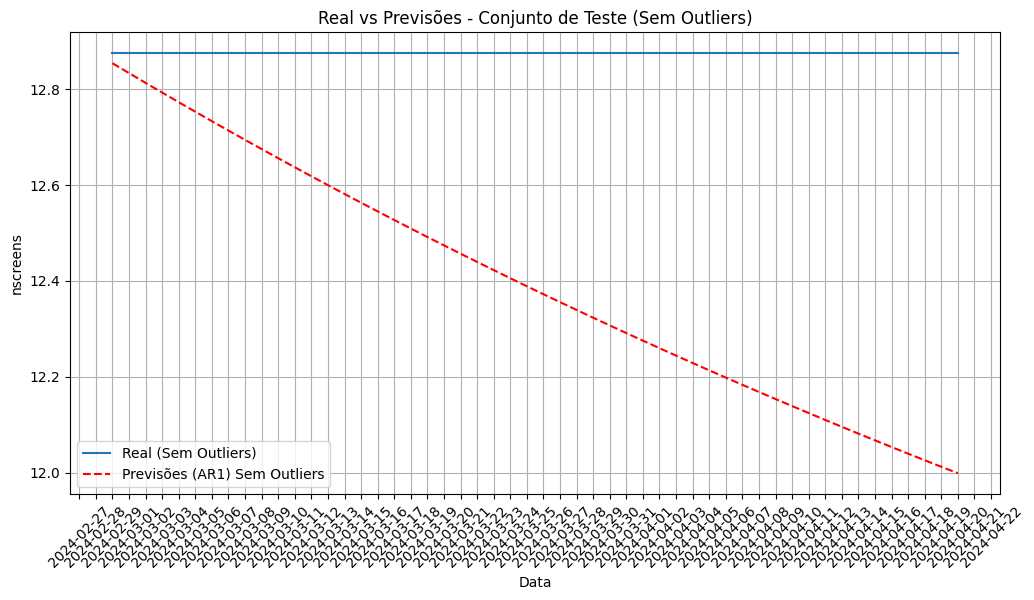

Mean Squared Error (Sem Outliers): 0.2921026461758134
Mean Absolute Error (Sem Outliers): 0.4784924417215353
R^2 Score (Sem Outliers): -2.3142755922063997e+28


In [27]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supondo que 'Screening_date' seja o índice e 'nscreens' seja a série temporal
d4.set_index('Screening_date', inplace=True)
series = d4['nscreens']

# Transformar a série em log
series_log = np.log(series.replace(0, np.nan))  # Substituir zeros para evitar log(0), você pode lidar com isso de outras formas

# Identificação de outliers usando o método IQR na série transformada
Q1 = series_log.quantile(0.25)
Q3 = series_log.quantile(0.75)
IQR = Q3 - Q1

# Definindo limites para detecção de outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removendo outliers
series_log_no_outliers = series_log[(series_log >= lower_bound) & (series_log <= upper_bound)]

# Dividir a série sem outliers em treino e teste
train_size = int(len(series_log_no_outliers) * 0.8)
train_log_no_outliers, test_log_no_outliers = series_log_no_outliers[:train_size], series_log_no_outliers[train_size:]

# Ajustar o modelo AR(1) no conjunto de treino sem outliers
model_no_outliers = AutoReg(train_log_no_outliers, lags=1)
model_fitted_no_outliers = model_no_outliers.fit()

# Fazer previsões no conjunto de teste sem outliers
predictions_log_no_outliers = model_fitted_no_outliers.predict(start=len(train_log_no_outliers), end=len(train_log_no_outliers) + len(test_log_no_outliers) - 1, dynamic=False)

# Transformar as previsões de volta ao espaço original
predictions_no_outliers = np.exp(predictions_log_no_outliers)
test_no_outliers = np.exp(test_log_no_outliers)

# Plotar os valores reais vs previsões sem outliers
plt.figure(figsize=(12, 6))
plt.plot(test_no_outliers.index, test_no_outliers, label='Real (Sem Outliers)')
plt.plot(test_no_outliers.index, predictions_no_outliers, color='red', linestyle='--', label='Previsões (AR1) Sem Outliers')
plt.title('Real vs Previsões - Conjunto de Teste (Sem Outliers)')
plt.xlabel('Data')
plt.ylabel('nscreens')
plt.legend()

# Formatar o eixo X para mostrar todas as datas
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Ajuste o intervalo se necessário

plt.grid(True)
plt.show()

# Calcular as métricas de avaliação
mse_no_outliers = mean_squared_error(test_no_outliers, predictions_no_outliers)
mae_no_outliers = mean_absolute_error(test_no_outliers, predictions_no_outliers)
r2_no_outliers = r2_score(test_no_outliers, predictions_no_outliers)

print(f'Mean Squared Error (Sem Outliers): {mse_no_outliers}')
print(f'Mean Absolute Error (Sem Outliers): {mae_no_outliers}')
print(f'R^2 Score (Sem Outliers): {r2_no_outliers}')

# random 
# Mean Squared Error (Sem Outliers): 8.825659847017915
# Mean Absolute Error (Sem Outliers): 2.2775597901655655
# R^2 Score (Sem Outliers): -1.3272051639539457

# split date
# Mean Squared Error (Sem Outliers): 0.2921026461758134
# Mean Absolute Error (Sem Outliers): 0.4784924417215353
# R^2 Score (Sem Outliers): -2.3142755922063997e+28




# MODELO ARMA

A combined ARMA model might capture both the autocorrelations and moving averages in the data. The slow decay in the ACF might indicate that an MA component could help improve the fit.

Modelo ARIMA melhores parâmetros

In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import itertools

# 1. Definir os intervalos de valores para p e q
p = range(0, 4)  # Exemplo: Testar valores de 0 a 3 para p
d = [0]  # Mantendo d=0, pois sabemos que a série é estacionária
q = range(0, 4)  # Exemplo: Testar valores de 0 a 3 para q

# 2. Criar a lista de todas as combinações possíveis de p, d, q
pdq = list(itertools.product(p, d, q))

# 3. Dividir os dados em treino (80%) e teste (20%)
train_size = int(len(d4) * 0.8)
y_train = d4['nscreens'][:train_size]
y_test = d4['nscreens'][train_size:]

# 4. Grid Search para encontrar a melhor combinação de p, d, q
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(y_train, order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
            best_model = model_fit
    except:
        continue

# 5. Exibir os melhores parâmetros encontrados
print(f"Melhor combinação de (p, d, q): {best_pdq} com AIC: {best_aic}")

# 6. Fazer previsões com o melhor modelo
y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 7. Avaliar o modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 6. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: ARIMA")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Melhor combinação de (p, d, q): (1, 0, 0) com AIC: -1396.7890445859916
# Modelo: ARIMA
# MAE: 2.142041943774356
# MSE: 7.49813531299078
# RMSE: 2.738272322649955
# R2: -0.9771551955193043
# ME: 2.037568047952738
# MAV: 11.228988121444878
# MPV: 0.1681699156516894
# RME: 0.15646387840523435
# RMAE: 0.1681699156516894

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\s

Melhor combinação de (p, d, q): (1, 0, 0) com AIC: -1396.7890445859916
Modelo: ARIMA
MAE: 2.142041943774356
MSE: 7.49813531299078
RMSE: 2.738272322649955
R2: -0.9771551955193043
ME: 2.037568047952738
MAV: 11.228988121444878
MPV: 0.1681699156516894
RME: 0.15646387840523435
RMAE: 0.1681699156516894


c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo ARIMA melhores parâmetros sem outliers

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.

Melhor combinação de (p, d, q): (1, 0, 0) com AIC: -1396.7890445859916
Modelo: ARIMA sem Outliers
MAE: 2.142041943774356
MSE: 7.49813531299078
RMSE: 2.738272322649955
R2: -0.9771551955193043
ME: 2.037568047952738
MAV: 11.228988121444878
MPV: 0.1681699156516894
RME: 0.15646387840523435
RMAE: 0.1681699156516894


c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


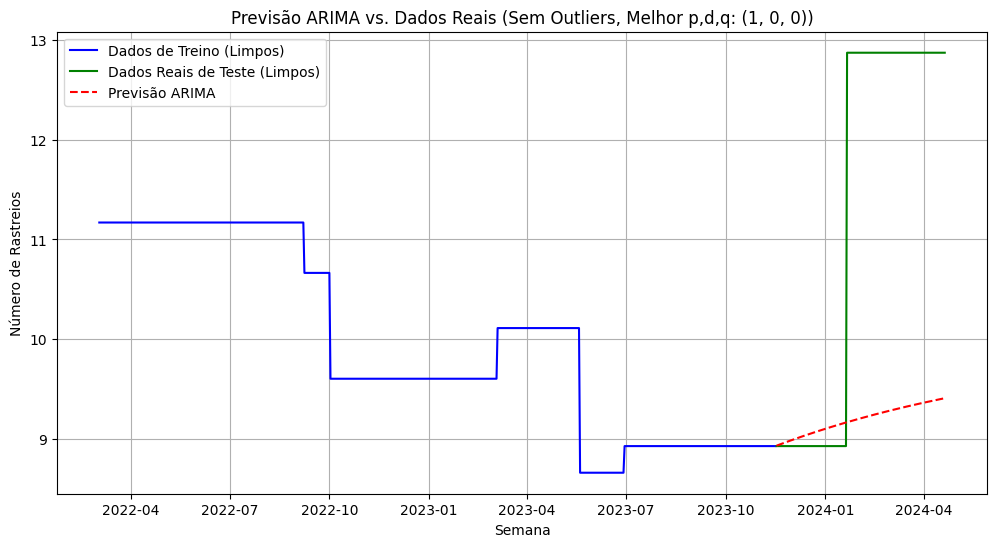

In [58]:
# 1. Identificação de Outliers usando o método IQR
Q1 = d4['nscreens'].quantile(0.25)
Q3 = d4['nscreens'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2. Remoção de Outliers
d4_clean = d4[(d4['nscreens'] >= lower_bound) & (d4['nscreens'] <= upper_bound)]

# 3. Definir os intervalos de valores para p e q
p = range(0, 4)  # Testar valores de 0 a 3 para p
d = [0]  # Mantendo d=0, pois a série é estacionária
q = range(0, 4)  # Testar valores de 0 a 3 para q

# 4. Criar a lista de todas as combinações possíveis de p, d, q
pdq = list(itertools.product(p, d, q))

# 5. Dividir os dados limpos em treino (80%) e teste (20%)
train_size = int(len(d4_clean) * 0.8)
y_train = d4_clean['nscreens'][:train_size]
y_test = d4_clean['nscreens'][train_size:]

# 6. Grid Search para encontrar a melhor combinação de p, d, q
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(y_train, order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
            best_model = model_fit
    except:
        continue

# 7. Exibir os melhores parâmetros encontrados
print(f"Melhor combinação de (p, d, q): {best_pdq} com AIC: {best_aic}")

# 8. Fazer previsões com o melhor modelo
y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 9. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: ARIMA sem Outliers")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Melhor combinação de (p, d, q): (1, 0, 0) com AIC: -1396.7890445859916
# Modelo: ARIMA sem Outliers
# MAE: 2.142041943774356
# MSE: 7.49813531299078
# RMSE: 2.738272322649955
# R2: -0.9771551955193043
# ME: 2.037568047952738
# MAV: 11.228988121444878
# MPV: 0.1681699156516894
# RME: 0.15646387840523435
# RMAE: 0.1681699156516894

# 10. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(d4_clean['Screening_date'][:train_size], y_train, label='Dados de Treino (Limpos)', color='blue')
plt.plot(d4_clean['Screening_date'][train_size:], y_test, label='Dados Reais de Teste (Limpos)', color='green')
plt.plot(d4_clean['Screening_date'][train_size:], y_pred, label='Previsão ARIMA', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title(f'Previsão ARIMA vs. Dados Reais (Sem Outliers, Melhor p,d,q: {best_pdq})')
plt.legend()
plt.grid(True)
plt.show()

# MODELO SARIMA

This model would be more appropriate given the seasonality and trend in the data. You can start with a model like SARIMA(p,d,q)(P,D,Q)[S] where p, q are AR and MA orders, and P, Q are the seasonal AR and MA orders, with S being the seasonal period.

In [7]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignorar avisos para modelos mal ajustados
warnings.filterwarnings("ignore")

# Definir os intervalos de valores para p, d, q, P, D, Q, e m
p = [1]
d = [0]
q = [0]
P = range(0, 4)
D = [0, 1]  # Testando tanto D=0 quanto D=1
Q = range(0, 4)
m = 7  # Sazonalidade semanal

# Criar a lista de todas as combinações possíveis de (p, d, q) e (P, D, Q, m)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

# Dividir os dados em treino (80%) e teste (20%)
train_size = int(len(d4) * 0.8)
y_train = d4['nscreens'][:train_size]
y_test = d4['nscreens'][train_size:]

# Grid Search para encontrar a melhor combinação de p, d, q, P, D, Q, m
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(y_train, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param
                best_model = model_fit
        except:
            continue

# Exibir os melhores parâmetros encontrados
print(f"Melhor combinação de (p, d, q): {best_pdq} e sazonal (P, D, Q, m): {best_seasonal_pdq} com AIC: {best_aic}")

# COM M=52
# Melhor combinação de (p, d, q): (1, 0, 0) e sazonal (P, D, Q, m): (0, 0, 0, 52) com AIC: -1402.4530735219505

# COM M=7
# Melhor combinação de (p, d, q): (1, 0, 0) e sazonal (P, D, Q, m): (0, 0, 0, 7) com AIC: -1402.4530735219505



Melhor combinação de (p, d, q): (1, 0, 0) e sazonal (P, D, Q, m): (0, 0, 0, 7) com AIC: -1402.4530735219505


MELHOR SARIMA

Modelo: SES
MAE: 2.573371173042028
MSE: 10.947118335859399
RMSE: 3.308642974976206
R2: -1.886604601041249
ME: 2.573371173042028
MAV: 11.228988121444878
MPV: 0.2015159172643522
RME: 0.2015159172643522
RMAE: 0.2015159172643522


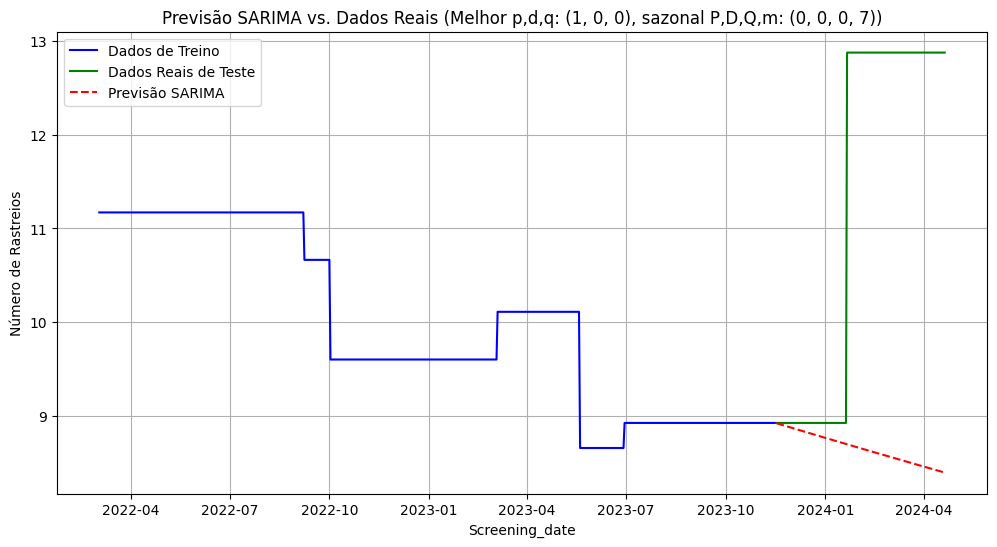

In [9]:
# Definindo o modelo SARIMA com as melhores combinações
p, d, q = 1, 0, 0
P, D, Q, m = 0, 0, 0, 7

# Criando o modelo
model = SARIMAX(y_train, 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Ajustando o modelo
sarima_model = model.fit(disp=False)

# Fazendo previsões
y_pred = sarima_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: SES")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: SARIMA MELHORES PARÂMETROS
# MAE: 2.573371173042028
# MSE: 10.947118335859399
# RMSE: 3.308642974976206
# R2: -1.886604601041249
# ME: 2.573371173042028
# MAV: 11.228988121444878
# MPV: 0.2015159172643522
# RME: 0.2015159172643522
# RMAE: 0.2015159172643522

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(d4['Screening_date'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(d4['Screening_date'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(d4['Screening_date'][train_size:], y_pred, label='Previsão SARIMA', color='red', linestyle='--')
plt.xlabel('Screening_date')
plt.ylabel('Número de Rastreios')
plt.title(f'Previsão SARIMA vs. Dados Reais (Melhor p,d,q: {best_pdq}, sazonal P,D,Q,m: {best_seasonal_pdq})')
plt.legend()
plt.grid(True)
plt.show()

# MODELO ES

ES can be particularly useful if you want to smooth out the time series data for forecasting. The Holt-Winters method, which includes seasonal components, might be appropriate here.

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(d4) * 0.8)
y_train = d4['nscreens'][:train_size]
y_test = d4['nscreens'][train_size:]

Simple Exponential Smoothing (SES)

Modelo: SES
MAE: 2.3042005420054203
MSE: 9.101725950476693
RMSE: 3.0169066857423172
R2: -1.4
ME: 2.3042005420054203
MAV: 11.228988121444878
MPV: 0.17896917791368927
RME: 0.17896917791368927
RMAE: 0.17896917791368927


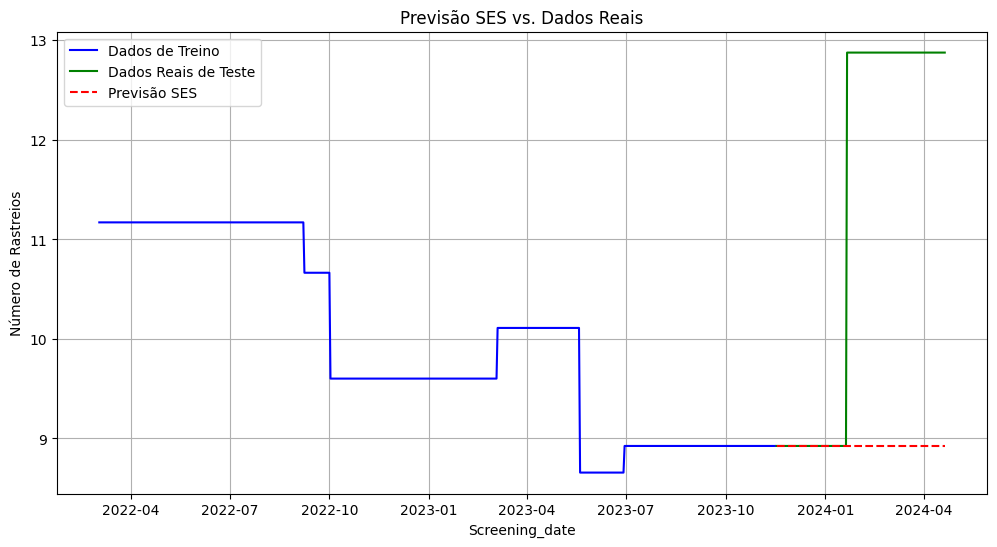

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# 2. Criar e ajustar o modelo SES
model = SimpleExpSmoothing(y_train).fit()

# 3. Fazer previsões
y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: SES")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')~



# 5. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(d4['Screening_date'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(d4['Screening_date'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(d4['Screening_date'][train_size:], y_pred, label='Previsão SES', color='red', linestyle='--')
plt.xlabel('Screening_date')
plt.ylabel('Número de Rastreios')
plt.title('Previsão SES vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()

Holt’s Linear Trend Model (Double Exponential Smoothing)

Modelo: HLTM
MAE: 2.5870945662871017
MSE: 11.051508581983516
RMSE: 3.324380932141128
R2: -1.914130873757113
ME: 2.5870945662871017
MAV: 11.228988121444878
MPV: 0.20264527060071788
RME: 0.20264527060071788
RMAE: 0.20264527060071788


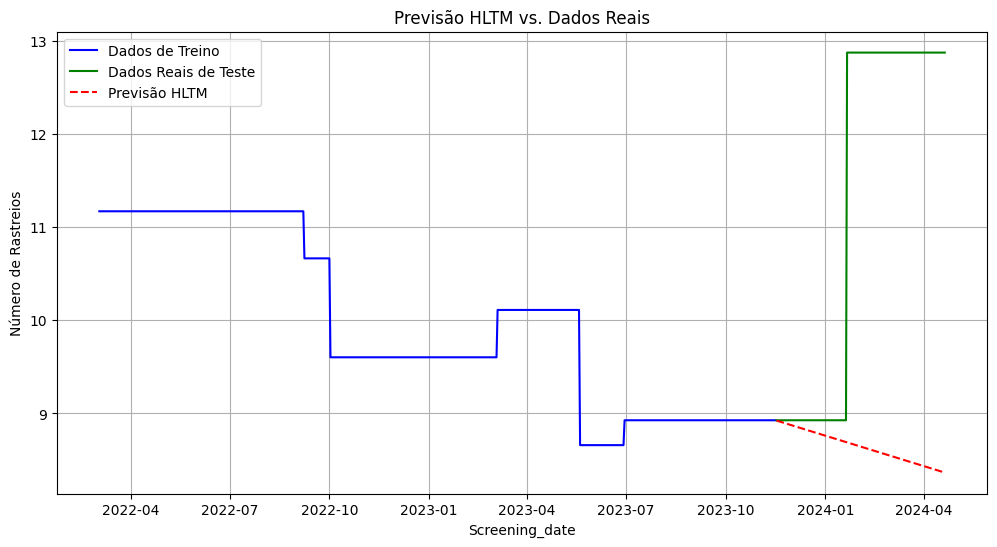

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 2. Criar e ajustar o modelo Holt's Linear Trend (Double Exponential Smoothing)
model = ExponentialSmoothing(y_train, trend='add').fit()

# 3. Fazer previsões
y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: HLTM")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: HLTM
# MAE: 2.5870945662871017
# MSE: 11.051508581983516
# RMSE: 3.324380932141128
# R2: -1.914130873757113
# ME: 2.5870945662871017
# MAV: 11.228988121444878
# MPV: 0.20264527060071788
# RME: 0.20264527060071788
# RMAE: 0.20264527060071788

# 5. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(d4['Screening_date'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(d4['Screening_date'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(d4['Screening_date'][train_size:], y_pred, label='Previsão HLTM', color='red', linestyle='--')
plt.xlabel('Screening_date')
plt.ylabel('Número de Rastreios')
plt.title('Previsão HLTM vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()

Holt-Winters Exponential Smoothing (Triple Exponential Smoothing)

Modelo: HWES
MAE: 2.5849271976273394
MSE: 11.039292154706848
RMSE: 3.3225430252604475
R2: -1.9109095698392045
ME: 2.584905102608742
MAV: 11.228988121444878
MPV: 0.20244986334938603
RME: 0.20244738765812717
RMAE: 0.20244986334938603


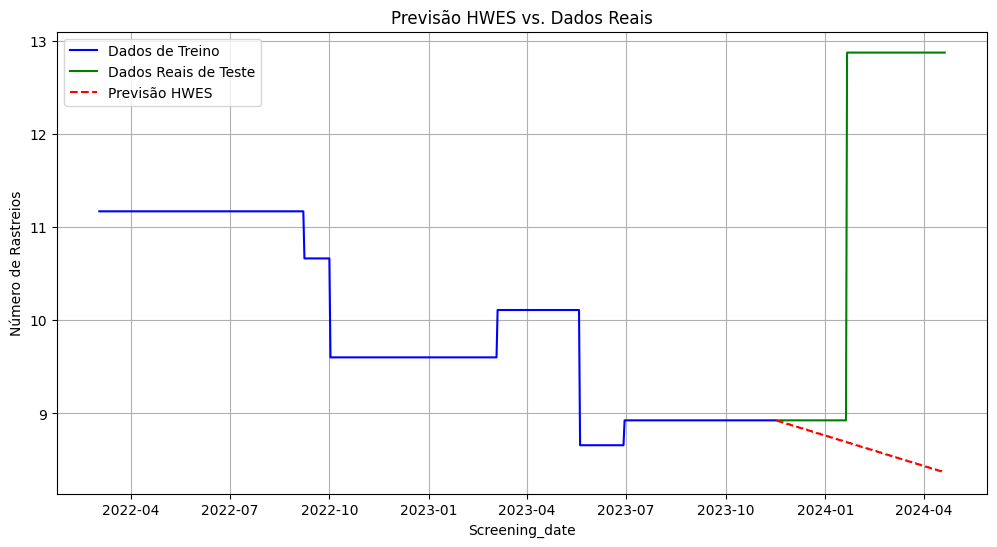

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 2. Criar e ajustar o modelo Holt-Winters (Triple Exponential Smoothing)
# Definindo sazonalidade com período de 52 semanas (ajuste conforme necessário)
model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=4).fit()

# 3. Fazer previsões
y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: HWES")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# Modelo: HWES
# MAE: 2.5849271976273394
# MSE: 11.039292154706848
# RMSE: 3.3225430252604475
# R2: -1.9109095698392045
# ME: 2.584905102608742
# MAV: 11.228988121444878
# MPV: 0.20244986334938603
# RME: 0.20244738765812717
# RMAE: 0.20244986334938603

# 5. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(d4['Screening_date'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(d4['Screening_date'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(d4['Screening_date'][train_size:], y_pred, label='Previsão HWES', color='red', linestyle='--')
plt.xlabel('Screening_date')
plt.ylabel('Número de Rastreios')
plt.title('Previsão HWES vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()